In [76]:
import os
import json
import itertools
import pandas as pd
from matplotlib import pylab as plt
from matplotlib import dates as mdates
import datetime
%matplotlib inline
import opentrain_analysis
reload(opentrain_analysis)

# Data structure for cached route_data:
# time - TBD
# data - list of entries. Each entry is a dict with the following structure:
#   info : {u'hours', u'num_trips', u'week_day'}
#   stops : [{u'arrival_on_time_pct', u'arrival_late_pct', 
#             u'departure_early_pct', u'departure_on_time_pct',
#             u'stop_id', u'arrival_early_pct', u'departure_late_pct'}]

<module 'opentrain_analysis' from 'opentrain_analysis.py'>

In [77]:
stop_lut = opentrain_analysis.get_stops()

In [78]:
SMALL_N_THRESHOLD = 10  # greater than

In [79]:
# Print route numbers that pass filter
routes = opentrain_analysis.get_routes_above_threshold(SMALL_N_THRESHOLD)
for route in routes:
    print(route)

1
2
3
4
5
6
7
8
9
10
11
12
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
34
35
37
38
39
40
41
42
43
44
47
48
49
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
75
77
78
80
81
83
84
87
88
89
90
93
94
95
96
97
104
106
107
108
109
118
120
121
123
124
125
145
152
153
154
157
161
203
207
210
221
225
246
248
270
292
302
310
316
317
318
435
437
528
533
538
539
552
560
621
622
677
679
690
696
802
921
922
923
927
931
942
968
990
1138
1143
1174
1175
1196
1197
1336
1337
1402
1442
1469
1512
1513
1516
1517
1519


In [81]:
# Look at results for one route ID
route_id = 2
OUTLIER_MUL = 3

df = opentrain_analysis.get_route_by_id(route_id, SMALL_N_THRESHOLD)

print '-----  Mean  -----'
means = df.mean()
print means
print '----- StdDev -----'
stds = df.std()
print stds

print "%d total records" % len(df)
lates = df[df['departure_late_pct'] > means['departure_late_pct']+OUTLIER_MUL*stds['departure_late_pct']]
print "%d records late departure > mean + %d*stddev" % (len(lates), OUTLIER_MUL)
#with pd.option_context('display.max_rows', 999, 'display.max_columns', 3):
pd.options.display.max_colwidth = 999
pd.options.display.max_rows = 999
#lates[['departure_late_pct','arrival_late_pct','url','num_trips','stop_id','month','year']].sort_values(by='departure_late_pct', ascending=False).head(999)
#all_hours = lates[(lates['hours'] == 0) & (lates['week_day'] == 1)]
#all_hours = lates[(lates['hours'] == 0)]
all_hours = lates
all_hours['stop_name_heb'] = [stop_lut[i][0] for i in all_hours['stop_id']]
all_hours[['departure_late_pct','url','month','year','stop_id','stop_name_heb']].sort_values(by=['year', 'month'], ascending=False).head(999)
#lates.groupby('month').count()

-----  Mean  -----
arrival_early_pct           0.125394
arrival_late_pct            0.127632
arrival_on_time_pct         0.746519
departure_early_pct         0.029273
departure_late_pct          0.123080
departure_on_time_pct       0.756738
hours                       1.176471
month                       5.460784
num_trips                  30.156863
stop_id                  3027.272727
year                     2015.225490
dtype: float64
----- StdDev -----
arrival_early_pct           0.165435
arrival_late_pct            0.125341
arrival_on_time_pct         0.182226
departure_early_pct         0.103646
departure_late_pct          0.130301
departure_on_time_pct       0.283847
hours                       2.834580
month                       3.670989
num_trips                  27.312158
stop_id                  1968.381979
year                        0.418091
dtype: float64
1122 total records
13 records late departure > mean + 3*stddev


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,departure_late_pct,url,month,year,stop_id,stop_name_heb
996,0.545455,http://otrain.org/#/201511/routes/2?day=5&time=,11,2015,2300,חיפה חוף הכרמל רזיאל
882,0.750000,http://otrain.org/#/201509/routes/2?day=6&time=,9,2015,3500,הרצליה
883,0.833333,http://otrain.org/#/201509/routes/2?day=6&time=,9,2015,3300,נתניה
884,0.833333,http://otrain.org/#/201509/routes/2?day=6&time=,9,2015,3100,חדרה מערב
885,0.833333,http://otrain.org/#/201509/routes/2?day=6&time=,9,2015,2800,בנימינה
886,0.833333,http://otrain.org/#/201509/routes/2?day=6&time=,9,2015,2300,חיפה חוף הכרמל רזיאל
887,0.750000,http://otrain.org/#/201509/routes/2?day=6&time=,9,2015,2100,חיפה מרכז השמונה
888,0.666667,http://otrain.org/#/201509/routes/2?day=6&time=,9,2015,800,קריית מוצקין
889,0.750000,http://otrain.org/#/201509/routes/2?day=6&time=,9,2015,1500,עכו
806,0.666667,http://otrain.org/#/201508/routes/2?day=5&time=,8,2015,3300,נתניה


Index([    u'arrival_early_pct',      u'arrival_late_pct',
         u'arrival_on_time_pct',   u'departure_early_pct',
          u'departure_late_pct', u'departure_on_time_pct',
                       u'hours',                 u'month',
                   u'num_trips',               u'stop_id',
                         u'url',              u'week_day',
                        u'year'],
      dtype='object')
19019


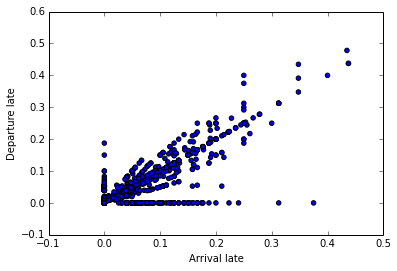

In [58]:
print(df.columns)
print(df.size)
plt.scatter(df['arrival_late_pct'], df['departure_late_pct'])
#plt.scatter(df['arrival_early_pct'], df['departure_early_pct'])
plt.xlabel('Arrival late')
plt.ylabel('Departure late')

1
2
3
4
5
6
7


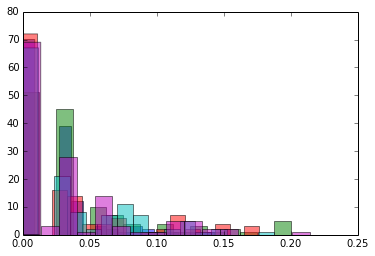

In [47]:
good_samples = df[df['num_trips'] > SMALL_N_THRESHOLD]
today = good_samples[2 == good_samples['week_day']]
for day in xrange(1, 8):
    print day
    today = good_samples[day == good_samples['week_day']]
    if len(today) > 0:
        plt.hist(today['departure_late_pct'].values, bins=16, alpha=0.5)
plt.show()

In [25]:
# Generate time series plot of late departures
route_id = 100
if os.path.isfile("%scache_%s.json" % (CACHE_PATH, route_id)):
    with open("%scache_%s.json" % (CACHE_PATH, route_id), 'r') as input_file:
        route_data = json.load(input_file)

data_for_plot = pd.DataFrame()
for time, data in route_data:
    data_for_plot_all = []
    for entry in data:
        # info : {u'hours', u'num_trips', u'week_day'}
        # stops : [{u'arrival_on_time_pct', u'arrival_late_pct', 
        #           u'departure_early_pct', u'departure_on_time_pct',
        #           u'stop_id', u'arrival_early_pct', u'departure_late_pct'}]
        if ('all' == entry['info']['week_day'] and 'all' == entry['info']['hours']):
            for stops in entry['stops']:
                if stops['stop_id'] == 4170:
                    tmp = pd.DataFrame({'time':datetime.datetime(time[0], time[1], 1),
                                        'departure_late_pct':stops['departure_late_pct']*100},
                                        index=[0])
                    data_for_plot = data_for_plot.append(tmp)

data_for_plot = data_for_plot.sort_values('time')

plt.scatter(xrange(len(data_for_plot)), data_for_plot.sort_values('time')['departure_late_pct'].values)
plt.annotate('Jun 2013', xy=(6, 5.6), xytext=(-2, 7),
            arrowprops=dict(facecolor='black', shrink=0.01, width=1, headwidth=8))
plt.xticks([])
plt.xlabel('Time')
plt.ylabel('Percent late departures')
plt.ylim([-1, 15])
plt.title('Late departures over time (Petah Tikva Kiryat Aryeh)')

KeyError: 'departure_late_pct'

In [ ]:
data_for_plot.reset_index().head(100)